# Testing cancelation of SRG transformations in momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ February 9, 2023

The SRG transformations are unitary and therefore satisfy the condition<br>

$$
\begin{align}
U^\dagger U &= I + \frac{1}{4} \sum_{\mathbf{k}, \mathbf{k'}, \mathbf{K}} \bigl[
    \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'})
    + \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
\bigr]
a^\dagger_{\frac{\mathbf{K}}{2}+\mathbf{k}} a^\dagger_{\frac{\mathbf{K}}{2}-\mathbf{k}}
a_{\frac{\mathbf{K}}{2}-\mathbf{k'}} a_{\frac{\mathbf{K}}{2}+\mathbf{k'}} \\
&= I
.
\end{align}
$$<br>

This implies that<br>

$$
\delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
+ \frac{1}{2} \sum_{\mathbf{k''}} \delta U(\mathbf{k},\mathbf{k''}) \delta U^\dagger(\mathbf{k''},\mathbf{k'})
= 0
.
$$<br>

In partial waves this looks like<br>

$$
\delta U_{LL'}(k,k') + \delta U^\dagger_{LL'}(k,k') + \frac{2}{\pi} \sum_{L''} \int dk'' k''^2
    \delta U_{LL''}(k,k'') \delta U^\dagger_{L''L'}(k'',k')
= 0
,
$$<br>
given partial wave channel quantum numbers $J$, $S$, and $T$.<br>

_Last update:_ March 20, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_ticks, set_rc_parameters
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.momentum_projection_operator import momentum_projection_operator
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import coupled_channel, replace_periods

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Check cancelation of matrix elements in partial wave basis

In [4]:
def load_H_evolved(
        kvnn, channel, generator, lamb, kmax=15.0, kmid=3.0, ntot=120,
        solver='ode', method='BDF', atol=1e-10, rtol=1e-10, wrt='s'
):
    """Load evolved Hamiltonian."""
    
    if solver == 'U':
        
        H_file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(H_file_name)
                               + ".txt")
                
        U_file_name = (
            f"U_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax_{kmax}"
            f"_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        U_evolved = np.loadtxt("./test_srg/" + replace_periods(U_file_name)
                               + ".txt")
        
        return H_evolved, U_evolved
        
    else:
        
        file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(file_name)
                               + ".txt")
    
        return H_evolved

In [5]:
def load_H_no_coupling(kvnn, channel, generator, lamb, kmax, kmid, ntot):
    """Loads the evolved Hamiltonian assuming there are no coupled channels."""
    
    file_name = (
        f"H_evolved_kvnn_{kvnn}_{channel}_no_coupling_{generator}_lamb_{lamb}"
        f"_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_ode_BDF_wrt_lambda"
    )
    
    H_evolved = np.loadtxt("./test_srg/" + replace_periods(file_name) + ".txt")
    
    return H_evolved

In [6]:
# kvnn = 6
kvnn = 111  # SMS N4LO 450 MeV
channel = '3S1'
# channel = '3P1'
# channel = '1P1'
kmax, kmid, ntot = 15.0, 3.0, 120
# kmax, kmid, ntot = 30.0, 4.0, 120  # Different mesh for AV18
generator, lamb = 'Wegner', 1.35
# generator, lamb = 'Wegner', 2.0
# generator, lamb = 'Wegner', 3.0

potential = Potential(kvnn, channel, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [7]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]
H_initial = potential.load_hamiltonian()

# Get H_evolved from current version generated by srg.py
H_evolved = potential.load_hamiltonian('srg', generator, lamb)

# # scipy.integrate.ode with BDF solving w.r.t. \lambda
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='ode',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
# )

# # scipy.integrate.solve_ivp with LSODA solving w.r.t. s
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
#     method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
# )

# SRG transformation with integration factors attached [unitless]
U_matrix = get_transformation(H_initial, H_evolved)

In [8]:
# # Initial and evolved Hamiltonians with integration factors attached [MeV]
# H_initial = potential.load_hamiltonian()

# # Load saved file
# H_evolved, U_matrix = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='U', method='BDF',
#     atol=1e-10, rtol=1e-10, wrt='lambda'
# )

In [9]:
# # Initial and evolved Hamiltonians with integration factors attached [MeV]
# H_initial = potential.load_hamiltonian()[:ntot, :ntot]  # No coupling to 3D1

# # Load 3S1-3S1 evolved with no coupling to 3D1
# H_evolved = load_H_no_coupling(kvnn, channel, generator, lamb, kmax, kmid,
#                                ntot)[:ntot, :ntot]

# # SRG transformation with integration factors attached [unitless]
# U_matrix = get_transformation(H_initial, H_evolved)
# print(U_matrix.shape)

In [10]:
# # Initial and evolved Hamiltonians with integration factors attached [MeV]
# H_initial = potential.load_hamiltonian()[ntot:, ntot:]  # No coupling to 3S1

# # Load 3D1-3D1 evolved with no coupling to 3S1
# H_evolved = load_H_no_coupling(kvnn, channel, generator, lamb, kmax, kmid,
#                                ntot)[ntot:, ntot:]

# # SRG transformation with integration factors attached [unitless]
# U_matrix = get_transformation(H_initial, H_evolved)
# print(U_matrix.shape)

In [11]:
# Identity matrix
I_matrix = np.eye(len(U_matrix))

# \delta U and \delta U^\dagger matrices
delta_U = U_matrix - I_matrix
delta_U_dag = (U_matrix - I_matrix).T

In [12]:
# \delta U 3S1-3S1 sub-block
delta_U_3S1_3S1 = delta_U[:ntot, :ntot]

# \delta U^\dagger 3S1-3S1 sub-block
delta_U_dag_3S1_3S1 = delta_U_dag[:ntot, :ntot]

# \delta U 3S1-3D1 sub-block
delta_U_3S1_3D1 = delta_U[:ntot, ntot:]

# \delta U^\dagger 3D1-3S1 sub-block
delta_U_dag_3D1_3S1 = delta_U_dag[ntot:, :ntot]

In [13]:
# \sum_k'' \delta U_{3S1-3S1}(k,k'') \delta U^\dagger_{3S1-3S1}(k'',k')
delta_U2_3S1_3S1 = delta_U_3S1_3S1 @ delta_U_dag_3S1_3S1

# \sum_k'' \delta U_{3S1-3D1}(k,k'') \delta U^\dagger_{3D1-3S1}(k'',k')
delta_U2_3S1_3D1 = delta_U_3S1_3D1 @ delta_U_dag_3D1_3S1

In [14]:
# Coupled channel
matrix = delta_U_3S1_3S1 + delta_U_dag_3S1_3S1 + (delta_U2_3S1_3S1
                                                  + delta_U2_3S1_3D1)

print(matrix)
print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[-2.79802564e-16  7.66991394e-18 -2.88182446e-18 ... -1.30341624e-19
  -1.25590534e-19 -3.23531975e-19]
 [ 7.66991394e-18 -6.21918443e-16 -4.15872689e-16 ... -6.43304530e-17
   6.07885680e-18 -4.21104907e-18]
 [-2.88182446e-18 -4.15872689e-16 -2.16541051e-15 ... -2.13957710e-17
   1.46829136e-17 -7.76393172e-17]
 ...
 [-1.30341624e-19 -6.43304530e-17 -2.13957710e-17 ...  2.33658443e-15
   4.05396745e-16 -2.94347337e-16]
 [-1.25590534e-19  6.07885680e-18  1.46829136e-17 ...  4.05396745e-16
   6.47583793e-16  8.09868530e-16]
 [-3.23531975e-19 -4.21104907e-18 -7.76393172e-17 ... -2.94347337e-16
   8.09868530e-16  1.77546915e-15]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.00000.



In [15]:
# # No coupling
# matrix = delta_U + delta_U_dag + delta_U @ delta_U_dag

# print(matrix)
# print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
# matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
# print("Norm of matrix without integration weights = "
#       f"{la.norm(matrix_no_weights):.5f}.\n")

In [16]:
def plot_delU_sum(
        k_array, matrix_no_weights, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,4.0),
        xlabel_size=16, ylabel_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)
    
    # We don't need the second output since it'll be the same as the first
    k_max = axes_limits[1] + 0.2  # Add a little extra to prevent white edges
    k_array_dense, _, matrix_dense = interpolate_matrix(
        k_array, k_array, matrix_no_weights, k_max, k_max)

    # --- Plot --- #
    c = ax.contourf(k_array_dense, k_array_dense, matrix_dense, levels,
                    cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks and tick labels
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    levels_ticks_strings = label_ticks(levels_ticks)  # Make these strings
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.set_yticklabels(levels_ticks_strings)
    cbar.ax.set_title(r"[fm$^3$]", fontsize=16, pad=15)

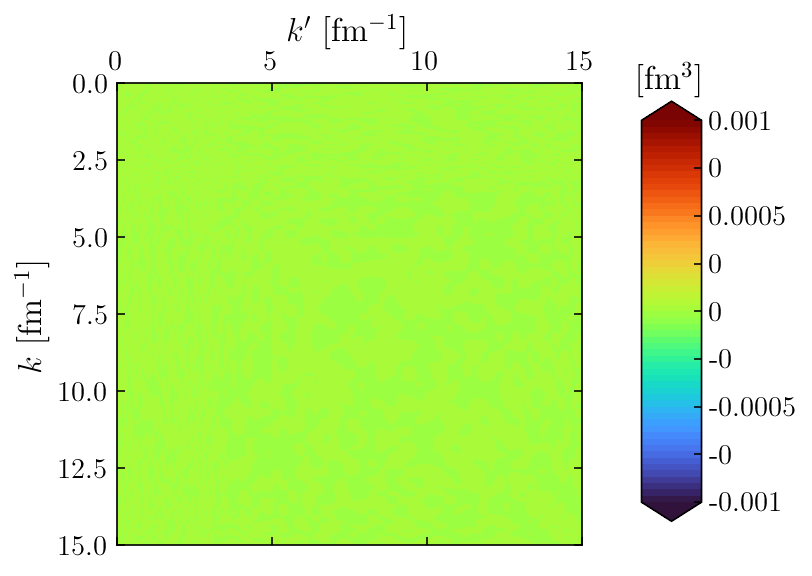

In [17]:
plot_delU_sum(
    k_array, matrix_no_weights, colorbar_limits=(-0.001,0.001),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

The above plot shows
$$
\delta U_{LL'}(k,k') + \delta U^\dagger_{LL'}(k,k') + \frac{2}{\pi} \sum_{L''} \int dk'' k''^2
    \delta U_{LL''}(k,k'') \delta U^\dagger_{L''L'}(k'',k')
$$
where integration factors have been divided out.

In [18]:
# delta_U_3S1_3S1_no_weights = unattach_weights_from_matrix(k_array, k_weights,
#                                                           delta_U_3S1_3S1)
# delta_U_dag_3S1_3S1_no_weights = unattach_weights_from_matrix(
#     k_array, k_weights, delta_U_dag_3S1_3S1
# )
# delta_U_linear = delta_U_3S1_3S1_no_weights + delta_U_dag_3S1_3S1_no_weights

In [19]:
# plot_delU_sum(
#     k_array, delta_U_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [20]:
# plot_delU_sum(
#     k_array, delta_U_dag_3S1_3S1_no_weights, colorbar_limits=(-0.5,0.5),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [21]:
# plot_delU_sum(
#     k_array, delta_U_linear, colorbar_limits=(-0.5,0.5), axes_limits=(0.0,4.0),
#     xlabel_size=16, ylabel_size=16
# )

In [22]:
# delta_U2_no_weights = unattach_weights_from_matrix(
#     k_array, k_array, 1/2*(delta_U2_3S1_3S1 + delta_U2_3S1_3D1)
# )

# plot_delU_sum(
#     k_array, delta_U2_no_weights, colorbar_limits=(-0.1,0.1),
#     axes_limits=(0.0,4.0), xlabel_size=16, ylabel_size=16
# )

In [23]:
# print((I_matrix+delta_U) @ (I_matrix+delta_U).T)

In [24]:
# print(I_matrix @ I_matrix + delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

In [25]:
# print(delta_U @ I_matrix + I_matrix @ delta_U_dag + delta_U @ delta_U_dag)

## Check that normalization of momentum projection operator is conserved

In [26]:
q = 2.0
mpo_initial = momentum_projection_operator(
    q, k_array, k_weights, coupled=potential.coupled_channel_bool
)

print(f"Unevolved norm = {la.norm(mpo_initial)}")

I_matrix = np.eye(len(mpo_initial))

mpo_I_matrix = I_matrix @ mpo_initial @ I_matrix
mpo_delU_matrix = delta_U @ mpo_initial @ I_matrix
mpo_delUdag_matrix = I_matrix @ mpo_initial @ delta_U_dag
mpo_delU2_matrix = delta_U @ mpo_initial @ delta_U_dag

mpo_evolved = (mpo_I_matrix + mpo_delU_matrix + mpo_delUdag_matrix
               + mpo_delU2_matrix)

print(f"Evolved norm = {la.norm(mpo_evolved)}")

Unevolved norm = 2.847882658769522
Evolved norm = 2.847882658769497


## Cancelation after interpolating $\delta U$ functions

In [27]:
# # Check that \delta U_{3S1-3S1} * \delta U^\dagger_{3S1-3S1} is equal to
# # \delta U_{3S1-3S1}^2

# delU_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3S1)

# delUdag_3S1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
#                                                delta_U_dag_3S1_3S1)

# product = np.zeros_like(delU_3S1_3S1)
# for i in range(ntot):
#     for j in range(ntot):
#         product[i,j] = delU_3S1_3S1[i,j] * delUdag_3S1_3S1[j,i]

# print(delU_3S1_3S1**2-product)

In [28]:
# # Do the same test for the 3S1-3D1 block
# delU_3S1_3D1 = unattach_weights_from_matrix(k_array, k_weights, delta_U_3S1_3D1)
# delUdag_3D1_3S1 = unattach_weights_from_matrix(k_array, k_weights,
#                                                delta_U_dag_3D1_3S1)

# product = np.zeros_like(delU_3S1_3D1)
# for i in range(ntot):
#     for j in range(ntot):
#         product[i,j] = delU_3S1_3D1[i,j] * delUdag_3D1_3S1[j,i]
        
# print(delU_3S1_3D1**2-product)

In [29]:
# COPIED FROM compare_to_lda.ipynb
def interpolate_delta_U(
        potential, channel, generator='Wegner', lamb=1.35,
        hermitian_conjugate=False, order=3
):
    """Function that returns interpolated \delta U(k, k'),
    \delta U^\dagger(k, k') or \delta U^2(k, k') given the partial wave channel.
    """
    
    kmax, kmid, ntot = potential.kmax, potential.kmid, potential.ntot
    
    # Get momentum mesh
    # k_array, k_weights = potential.load_mesh()
    # ntot = potential.ntot
    k_array, k_weights = momentum_mesh(kmax, kmid, ntot)

    # Initial Hamiltonian
    H_initial = potential.load_hamiltonian()
    
#     # Evolved Hamiltonian
#     H_evolved = potential.load_hamiltonian('srg', generator, lamb)

    # scipy.integrate.solve_ivp with LSODA solving w.r.t. s
    if channel[:3] == '3S1' or channel[:3] == '3D1':
#         H_evolved = load_H_evolved(
#             potential.kvnn, '3S1', generator, lamb, kmax, kmid, ntot,
#             solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
#         )
        H_evolved, U_matrix_weights = load_H_evolved(
            potential.kvnn, '3S1', generator, lamb, kmax, kmid, ntot,
            solver='U', method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
        )
    else:
#         H_evolved = load_H_evolved(
#             potential.kvnn, channel, generator, lamb, kmax, kmid, ntot,
#             solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
#         )
        H_evolved, U_matrix_weights = load_H_evolved(
            potential.kvnn, channel, generator, lamb, kmax, kmid, ntot,
            solver='U', method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
        )
    
#     # Get SRG transformation from Hamiltonians
#     U_matrix_weights = get_transformation(H_initial, H_evolved)
    
    # Calculate \delta U = U - I
    I_matrix_weights = np.eye(len(H_initial), len(H_initial))
    if hermitian_conjugate:
        delU_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    else:
        delU_matrix_weights = U_matrix_weights - I_matrix_weights

    # Get specific sub-block if coupled-channel
    if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,ntot:])
    elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,:ntot])
    elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[ntot:,ntot:])
    else:
        delU_matrix = unattach_weights_from_matrix(
            k_array, k_weights, delU_matrix_weights[:ntot,:ntot])
        
    # Interpolate \delta U(k, k') or \delta U^\dagger(k, k')
    delU_func = RectBivariateSpline(k_array, k_array, delU_matrix, kx=order,
                                    ky=order)
#     delU_func = RegularGridInterpolator((k_array, k_array), delU_matrix,
#                                         method='nearest')
    
    return delU_func

In [30]:
# COPIED FROM compare_to_lda.ipynb
def get_delta_U_functions(
    potential, channel, generator='Wegner', lamb=1.35, order=3
):
    
    if channel == '3S1':
        channels = ('3S1-3S1', '3S1-3D1', '3D1-3S1')
    else:
        channels = [channel]

    delta_U_functions = {}
    delta_U_dagger_functions = {}
    for ichannel in channels:
        delta_U_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, generator, lamb, order=order)
        delta_U_dagger_functions[ichannel] = interpolate_delta_U(
            potential, ichannel, generator, lamb, hermitian_conjugate=True,
            order=order
        )

    return delta_U_functions, delta_U_dagger_functions

In [31]:
# Create a Gaussian quadrature array from max/min of the default array, but with
# no kmid, and less points.
k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 100)
# k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 500,
#                                                       xmin=k_array[0])
# k_array_new, k_weights_new = k_array, k_weights

k_2d_grid, kp_2d_grid = np.meshgrid(k_array_new, k_array_new, indexing='ij')
k_3d_grid, kpp_3d_grid, kp_3d_grid = np.meshgrid(k_array_new, k_array_new,
                                                 k_array_new, indexing='ij')
_, dkpp_3d_grid, _ = np.meshgrid(
    k_array_new, 2/np.pi*k_weights_new * k_array_new**2, k_array_new,
    indexing='ij'
)

In [32]:
# Call interpolated functions and create new arrays

# delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
#     potential, channel, generator, lamb, order=1)  # Linear
delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
    potential, channel, generator, lamb, order=3)  # Cubic
# delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
#     potential, channel, generator, lamb, order=5)  # Quintic

# Use this code for RectBivariateSpline
deltaU_3S1_3S1 = delta_U_functions['3S1-3S1'].ev(k_2d_grid, kp_2d_grid)
deltaUdag_3S1_3S1 = delta_U_dagger_functions['3S1-3S1'].ev(k_2d_grid, kp_2d_grid)

deltaU2 = np.sum(
    (
        delta_U_functions['3S1-3S1'].ev(k_3d_grid, kpp_3d_grid)
        * delta_U_dagger_functions['3S1-3S1'].ev(kpp_3d_grid, kp_3d_grid)
        + delta_U_functions['3S1-3D1'].ev(k_3d_grid, kpp_3d_grid)
        * delta_U_dagger_functions['3D1-3S1'].ev(kpp_3d_grid, kp_3d_grid)
    ) * dkpp_3d_grid,
    axis=1
)

# # Use this code for RegularGridInterpolator
# deltaU_3S1_3S1 = delta_U_functions['3S1-3S1']((k_2d_grid, kp_2d_grid))
# deltaUdag_3S1_3S1 = delta_U_dagger_functions['3S1-3S1']((k_2d_grid, kp_2d_grid))

# deltaU2 = np.sum(
#     (
#         delta_U_functions['3S1-3S1']((k_3d_grid, kpp_3d_grid))
#         * delta_U_dagger_functions['3S1-3S1']((kpp_3d_grid, kp_3d_grid))
#         + delta_U_functions['3S1-3D1']((k_3d_grid, kpp_3d_grid))
#         * delta_U_dagger_functions['3D1-3S1']((kpp_3d_grid, kp_3d_grid))
#     ) * dkpp_3d_grid,
#     axis=1
# )

In [33]:
# Repeat the steps from above
matrix_no_weights = deltaU_3S1_3S1 + deltaUdag_3S1_3S1 + deltaU2
print(matrix_no_weights)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[ 3.03991126e-06 -4.35173526e-06 -3.54289065e-06 ...  2.39211281e-12
   3.04213866e-12  5.52815564e-12]
 [-4.35173526e-06 -2.79890449e-06 -3.61260928e-06 ...  2.03528884e-12
   2.86429298e-12  5.47361156e-12]
 [-3.54289065e-06 -3.61260928e-06 -3.56676917e-06 ...  3.43300845e-13
   2.02093383e-12  5.21487275e-12]
 ...
 [ 2.39211281e-12  2.03528884e-12  3.43300845e-13 ... -5.46929552e-08
  -2.49205811e-08 -5.25114744e-09]
 [ 3.04213866e-12  2.86429298e-12  2.02093383e-12 ... -2.49205811e-08
  -9.06657562e-09  1.13405244e-09]
 [ 5.52815564e-12  5.47361156e-12  5.21487275e-12 ... -5.25114744e-09
   1.13405244e-09  4.69128424e-09]]
Norm of matrix without integration weights = 0.00006.



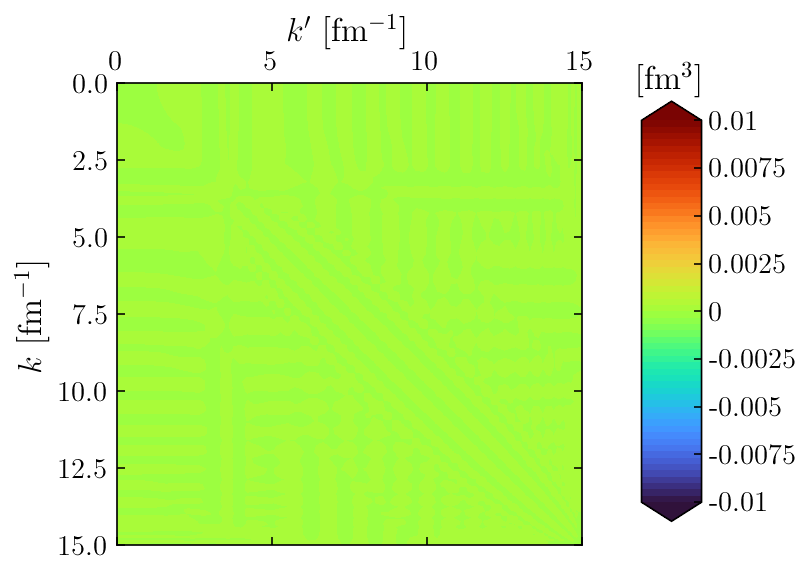

In [34]:
plot_delU_sum(
    k_array_new, matrix_no_weights, colorbar_limits=(-0.01,0.01),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

Normalization of cancelation matrix (matrix that should be entirely zero):<br>
* Linear `RectBivariateSpline`: 0.04434
* Cubic `RectBivariateSpline`: 0.01108
* Quintic `RectBivariateSpline`: 0.13699
* Nearest `RegularGridInterpolator`: 0.14537

## Repeating the same tests as above but for $^{1}S_0$

In [35]:
channel = '1S0'

potential = Potential(kvnn, channel, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [36]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]
H_initial = potential.load_hamiltonian()

In [37]:
H_evolved = potential.load_hamiltonian('srg', generator, lamb)

# # scipy.integrate.ode with BDF solving w.r.t. \lambda
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='ode',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
# )

# # scipy.integrate.solve_ivp with LSODA solving w.r.t. s
# H_evolved = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
#     method='LSODA', atol=1e-10, rtol=1e-10, wrt='s'
# )

# SRG transformation with integration factors attached [unitless]
U_matrix = get_transformation(H_initial, H_evolved)

# # Load saved file
# H_evolved, U_matrix = load_H_evolved(
#     kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='U', method='BDF',
#     atol=1e-10, rtol=1e-10, wrt='lambda'
# )

# Identity matrix
I_matrix = np.eye(len(U_matrix), len(U_matrix))

In [38]:
# \delta U and \delta U^\dagger matrices
delta_U = U_matrix - I_matrix
delta_U_dag = (U_matrix - I_matrix).T

In [39]:
# \sum_k'' \delta U(k,k'') \delta U^\dagger(k'',k')
delta_U2 = delta_U @ delta_U_dag

In [40]:
matrix = delta_U + delta_U_dag + delta_U2
print(matrix)
print(f"Norm of matrix with integration weights = {la.norm(matrix):.5f}.\n")
matrix_no_weights = unattach_weights_from_matrix(k_array, k_weights, matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[-5.85073934e-14 -1.47934454e-14 -4.54741400e-14 ... -1.07531488e-17
  -2.72150882e-17 -2.62165504e-17]
 [-1.47934454e-14  9.04793833e-14 -3.65140962e-13 ... -8.70353557e-17
  -2.18777729e-16 -2.10517427e-16]
 [-4.54741400e-14 -3.65140962e-13 -1.30117130e-12 ... -2.78463763e-16
  -6.76475897e-16 -6.47244664e-16]
 ...
 [-1.07531488e-17 -8.70353557e-17 -2.78463763e-16 ... -1.05529993e-10
  -3.98927302e-11 -5.17464062e-12]
 [-2.72150882e-17 -2.18777729e-16 -6.76475897e-16 ... -3.98927302e-11
  -4.49849920e-11 -2.43605193e-11]
 [-2.62165504e-17 -2.10517427e-16 -6.47244664e-16 ... -5.17464062e-12
  -2.43605193e-11 -1.80004196e-11]]
Norm of matrix with integration weights = 0.00000.

Norm of matrix without integration weights = 0.00002.



In [41]:
# Create a Gaussian quadrature array from max/min of the default array, but with
# no kmid, and less points
k_array_new, k_weights_new = gaussian_quadrature_mesh(k_array[-1], 100)

k_2d_grid, kp_2d_grid = np.meshgrid(k_array_new, k_array_new, indexing='ij')
k_3d_grid, kpp_3d_grid, kp_3d_grid = np.meshgrid(k_array_new, k_array_new,
                                                 k_array_new, indexing='ij')
_, dkpp_3d_grid, _ = np.meshgrid(
    k_array_new, 2/np.pi*k_weights_new * k_array_new**2, k_array_new,
    indexing='ij'
)

In [42]:
# Call interpolated functions and create new arrays

delta_U_functions, delta_U_dagger_functions = get_delta_U_functions(
    potential, channel, generator, lamb, order=3)  # Cubic

# Use this code for RectBivariateSpline
deltaU_1S0 = delta_U_functions['1S0'].ev(k_2d_grid, kp_2d_grid)
deltaUdag_1S0 = delta_U_dagger_functions['1S0'].ev(k_2d_grid, kp_2d_grid)

deltaU2_1S0 = np.sum((delta_U_functions['1S0'].ev(k_3d_grid, kpp_3d_grid)
    * delta_U_dagger_functions['1S0'].ev(kpp_3d_grid, kp_3d_grid))
    * dkpp_3d_grid, axis=1
)

# # Use this code for RegularGridInterpolator
# deltaU_1S0 = delta_U_functions['1S0']((k_2d_grid, kp_2d_grid))
# deltaUdag_1S0 = delta_U_dagger_functions['1S0']((k_2d_grid, kp_2d_grid))

# deltaU2_1S0 = np.sum((delta_U_functions['1S0']((k_3d_grid, kpp_3d_grid))
#     * delta_U_dagger_functions['1S0']((kpp_3d_grid, kp_3d_grid)))
#     * dkpp_3d_grid, axis=1
# )

In [43]:
# Repeat the steps from above
matrix_no_weights = deltaU_1S0 + deltaUdag_1S0 + deltaU2_1S0
print(matrix_no_weights)
print("Norm of matrix without integration weights = "
      f"{la.norm(matrix_no_weights):.5f}.\n")

[[-1.11901043e-05  1.46495361e-06 -7.72243403e-07 ...  2.74504944e-12
   9.54313650e-14 -3.39537755e-12]
 [ 1.46495361e-06 -6.74927423e-07 -6.81732603e-07 ...  2.85408970e-12
   1.49169952e-13 -3.37956497e-12]
 [-7.72243403e-07 -6.81732603e-07 -6.68389797e-07 ...  3.37201676e-12
   4.04420585e-13 -3.30449062e-12]
 ...
 [ 2.74504944e-12  2.85408970e-12  3.37201676e-12 ... -2.00843803e-08
  -9.14082300e-09 -1.93712987e-09]
 [ 9.54313650e-14  1.49169952e-13  4.04420585e-13 ... -9.14082300e-09
  -3.33688634e-09  3.86168415e-10]
 [-3.39537755e-12 -3.37956497e-12 -3.30449062e-12 ... -1.93712987e-09
   3.86168415e-10  1.67987675e-09]]
Norm of matrix without integration weights = 0.00004.



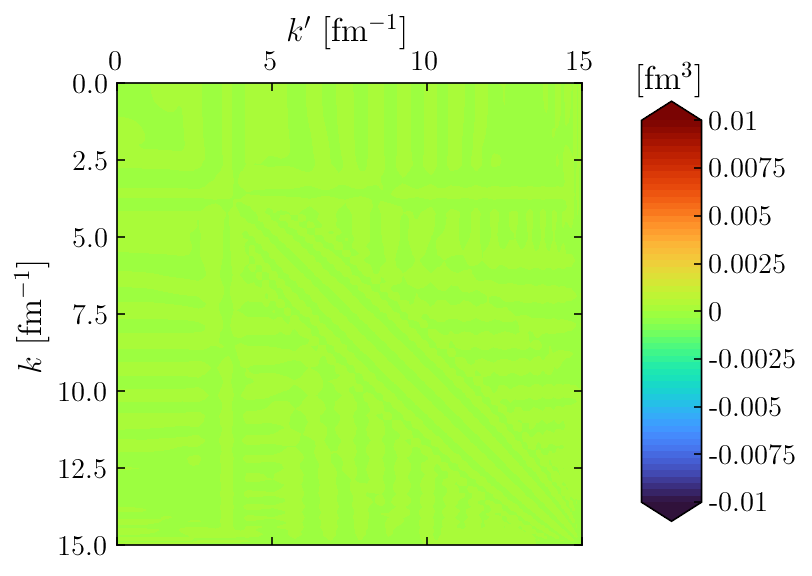

In [44]:
plot_delU_sum(
    k_array_new, matrix_no_weights, colorbar_limits=(-0.01,0.01),
    axes_limits=(0.0,15.0), xlabel_size=16, ylabel_size=16
)

In [45]:
# Is the U(k, k') defined on the new k_array even unitary?
from scripts.integration import attach_weights_to_matrix

delU_matrix_weights_new = attach_weights_to_matrix(k_array_new, k_weights_new,
                                                   deltaU_1S0)

ntot_new = len(k_array_new)
I_matrix = np.eye(ntot_new, ntot_new)
U = I_matrix + delU_matrix_weights_new
zero_matrix = I_matrix - U @ U.T

In [46]:
print(zero_matrix)
print(la.norm(I_matrix - U @ U.T)/np.sqrt(ntot_new))
print(la.norm(I_matrix)/np.sqrt(ntot_new))
print(la.norm(U @ U.T)/np.sqrt(ntot_new))

[[ 1.80522264e-13 -1.90164277e-13  3.08588995e-13 ... -5.91056134e-16
  -1.64165936e-17  3.83142341e-16]
 [-1.90164277e-13  7.03659353e-13  2.18907366e-12 ... -4.93817252e-15
  -2.06202223e-16  3.06445296e-15]
 [ 3.08588995e-13  2.18907366e-12  6.60660415e-12 ... -1.79601322e-14
  -1.72094270e-15  9.22396925e-15]
 ...
 [-5.91056134e-16 -4.93817252e-15 -1.79601322e-14 ...  5.76408756e-08
   2.09590111e-08  2.91356285e-09]
 [-1.64165936e-17 -2.06202223e-16 -1.72094270e-15 ...  2.09590111e-08
   6.11280082e-09 -4.64040361e-10]
 [ 3.83142341e-16  3.06445296e-15  9.22396925e-15 ...  2.91356285e-09
  -4.64040361e-10 -1.32414812e-09]]
6.370638201863122e-06
1.0
0.9999981095032453


## Testing cancelation of matrix elements with spherical harmonics included

$$
0 = \delta U_{L L'}(k, k') + \delta U^{\dagger}_{L L'}(k, k')
    + \frac{2}{\pi} \sum_{L'' M_L''} \frac{1}{2L''+1} \int dq q^2 \int d\Omega_{\mathbf{q}}
        \delta U_{L L''}(k, q)
        Y^*_{L'' M_L''}(\Omega_{\mathbf{q}}) Y_{L'' M_L''}(\Omega_{\mathbf{q}})
        \delta U^{\dagger}_{L'' L'}(q, k')
$$

_Note, this only works when you average over $M_L''$ as opposed to summing with no factor of $\frac{1}{2L''+1}$._

In [47]:
from scipy.special import sph_harm

In [48]:
def get_channel_quantum_numbers(channel):
    """Gets the quantum numbers of a partial wave channel."""
    
    # Total orbital angular momentum L' = 0, 1, 2, ...
    if channel[1] == 'S':
        Lp = 0
    elif channel[1] == 'P':
        Lp = 1
    elif channel[1] == 'D':
        Lp = 2
    elif channel[1] == 'F':
        Lp = 3
    elif channel[1] == 'G':
        Lp = 4
    elif channel[1] == 'H':
        Lp = 5
    else:
        raise RuntimeError("Channel L' exceeds the range of the function.")
    
    # Total orbital angular momentum L = 0, 1, 2, ...
    if coupled_channel(channel[:3]):
        
        if channel[5] == 'S':
            L = 0
        elif channel[5] == 'P':
            L = 1
        elif channel[5] == 'D':
            L = 2
        elif channel[5] == 'F':
            L = 3
        elif channel[5] == 'G':
            L = 4
        elif channel[5] == 'H':
            L = 5
        else:
            raise RuntimeError("Channel L exceeds the range of the function.")
        
    # L = L' if the channel is not coupled
    else:
        
        L = Lp
        
    # Total spin S = 0 or 1
    S = int((int(channel[0])-1)/2)
    
    # Total angular momentum J = 0, 1, 2, ...
    J = int(channel[2])
            
    return Lp, L, S, J

In [49]:
kvnn = 111  # SMS N4LO 450 MeV
kmax, kmid, ntot = 15.0, 3.0, 120
generator, lamb = 'Wegner', 1.35

In [50]:
channel = '1S0'
# channel = '3S1-3S1'
# channel = '3D1-3D1'

In [51]:
# Set channel argument to be compatible with potential functions
if channel[:3] in ['3S1', '3D1']:  # 3S1-3D1
    channel_arg = '3S1'
else:  # 1S0
    channel_arg = channel[:3]

potential = Potential(kvnn, channel_arg, kmax, kmid, ntot)
k_array, k_weights = potential.load_mesh()

In [52]:
# Initial and evolved Hamiltonians with integration factors attached [MeV]

# No coupling to 3D1
if channel == '3S1-3S1':
    
    H_initial = potential.load_hamiltonian()[:ntot, :ntot]
    H_evolved = load_H_no_coupling(kvnn, channel_arg, generator, lamb, kmax,
                                   kmid, ntot)[:ntot, :ntot]

# No coupling to 3S1
elif channel == '3D1-3D1':
    
    H_initial = potential.load_hamiltonian()[ntot:, ntot:]
    H_evolved = load_H_no_coupling(kvnn, channel_arg, generator, lamb, kmax,
                                   kmid, ntot)[ntot:, ntot:]

# 1S0    
else:
    
    H_initial = potential.load_hamiltonian()
    H_evolved = load_H_no_coupling(kvnn, channel_arg, generator, lamb, kmax,
                                   kmid, ntot)

In [53]:
# SRG transformation with integration factors attached [unitless]
U_matrix = get_transformation(H_initial, H_evolved)

# Identity matrix
I_matrix = np.eye(len(U_matrix), len(U_matrix))

# \delta U and \delta U^\dagger matrices [unitless]
delta_U_weights = U_matrix - I_matrix
delta_U_dag_weights = (U_matrix - I_matrix).T

# Remove integration factors from \delta U's [fm^3]
delta_U = unattach_weights_from_matrix(k_array, k_weights, delta_U_weights)
delta_U_dag = unattach_weights_from_matrix(k_array, k_weights,
                                           delta_U_dag_weights)

In [54]:
# Interpolate delta U's
delta_U_func = RectBivariateSpline(k_array, k_array, delta_U)
delta_U_dag_func = RectBivariateSpline(k_array, k_array, delta_U_dag)

In [55]:
# Create arrays for angular integrations
theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 9)
phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 13)

In [56]:
# Create 5-D meshgrids for integration
k_grid, kp_grid, q_grid, theta_q_grid, phi_q_grid = np.meshgrid(
    k_array, k_array, k_array, theta_array, phi_array, indexing='ij')
_, _, dq_grid, dtheta_q_grid, dphi_q_grid = np.meshgrid(
    k_weights, k_weights, k_weights, theta_weights, phi_weights, indexing='ij')

In [57]:
# Evaluate integrand

jacobian = (dq_grid * q_grid ** 2 * dtheta_q_grid * np.sin(theta_q_grid)
            * dphi_q_grid)
delU_5D_array = delta_U_func.ev(k_grid, q_grid)
delUdag_5D_array = delta_U_dag_func.ev(q_grid, kp_grid)

# Get orbital angular momentum
L, Lp, _, _ = get_channel_quantum_numbers(channel)

# Loop over M_L'' where L'' will be the same as L and L' for uncoupled channel
integrand = np.zeros_like(jacobian, dtype='complex')
for M_Lpp in np.arange(-L, L+1, 1):
    
    # Y_{L M_L''}(\Omega_q)
    Y_L_q_grid = sph_harm(M_Lpp, L, phi_q_grid, theta_q_grid)

    integrand += (jacobian * delU_5D_array * delUdag_5D_array
                  * np.conj(Y_L_q_grid) * Y_L_q_grid)

# Integrate over \phi_q, \theta_q, and q leaving k and k' dependence
delta_U2 = 2/np.pi * np.sum(
    np.sum(np.sum(integrand, axis=-1), axis=-1), axis=-1
)

In [58]:
# zero_matrix = delta_U + delta_U_dag + delta_U2  # fm^3
zero_matrix = delta_U + delta_U_dag + delta_U2 / (2*L+1)  # fm^3
print(zero_matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(zero_matrix):.5f}.\n")

[[ 3.50544494e-07+0.j  5.01153216e-11+0.j -8.75155365e-11+0.j ...
   4.95774492e-16+0.j  1.71833776e-14+0.j  9.34232570e-15+0.j]
 [ 5.01153147e-11+0.j  5.31406721e-09+0.j  6.76304658e-10+0.j ...
   9.55458697e-14+0.j  6.20374618e-16+0.j -1.95550803e-13+0.j]
 [-8.75155087e-11+0.j  6.76304714e-10+0.j  2.67067167e-10+0.j ...
   7.78969869e-15+0.j  3.14459658e-14+0.j -2.37384241e-14+0.j]
 ...
 [ 4.95774492e-16+0.j  9.55458697e-14+0.j  7.78969869e-15+0.j ...
  -1.32322640e-16+0.j -2.19544587e-17+0.j  1.55458710e-16+0.j]
 [ 1.71833776e-14+0.j  6.20374618e-16+0.j  3.14459658e-14+0.j ...
  -2.19546705e-17+0.j  1.15080014e-16+0.j -1.62048202e-16+0.j]
 [ 9.34232570e-15+0.j -1.95550803e-13+0.j -2.37384241e-14+0.j ...
   1.55458498e-16+0.j -1.62048414e-16+0.j  1.23991605e-15+0.j]]
Norm of matrix without integration weights = 0.00000.



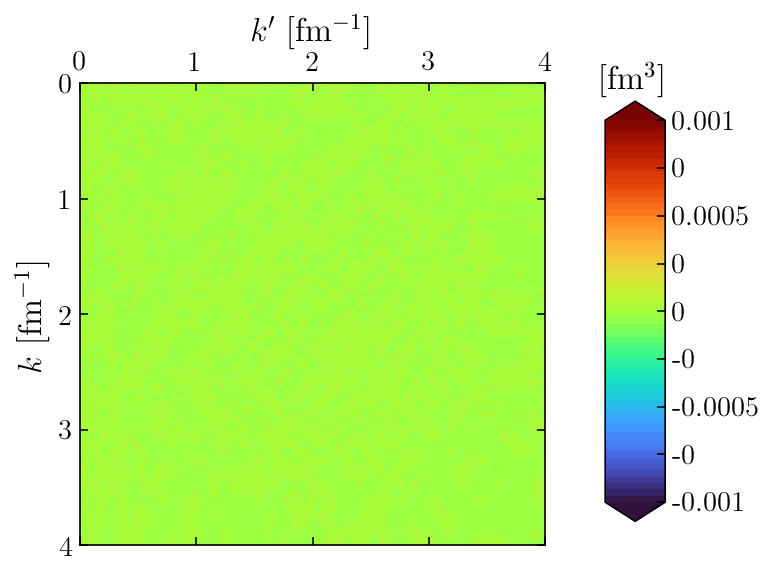

In [59]:
plot_delU_sum(k_array, zero_matrix.real, colorbar_limits=(-1e-3,1e-3))

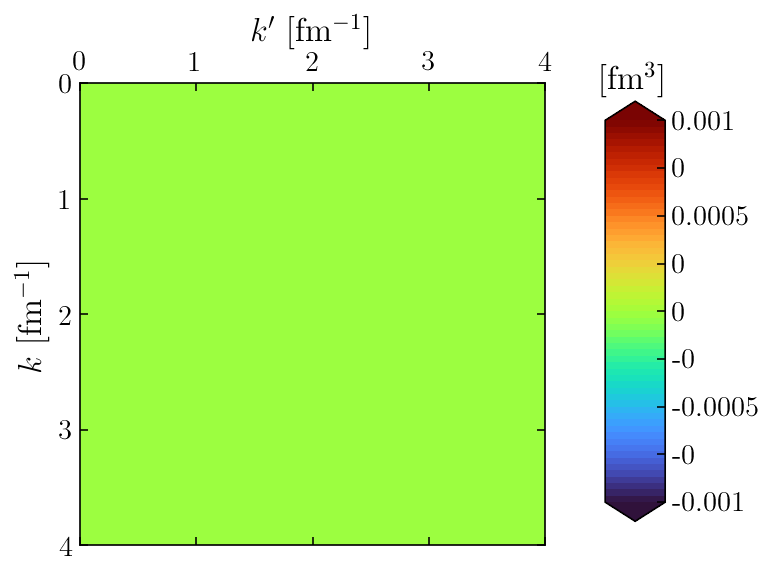

In [60]:
plot_delU_sum(k_array, zero_matrix.imag, colorbar_limits=(-1e-3,1e-3))

Try fixing $M_L''$.

In [61]:
# Evaluate integrand

jacobian = (dq_grid * q_grid ** 2 * dtheta_q_grid * np.sin(theta_q_grid)
            * dphi_q_grid)
delU_5D_array = delta_U_func.ev(k_grid, q_grid)
delUdag_5D_array = delta_U_dag_func.ev(q_grid, kp_grid)

# Get orbital angular momentum
L, Lp, _, _ = get_channel_quantum_numbers(channel)

# Fix M_L'' = L
Y_L_q_grid = sph_harm(L, L, phi_q_grid, theta_q_grid)

integrand = (jacobian * delU_5D_array * delUdag_5D_array
             * np.conj(Y_L_q_grid) * Y_L_q_grid)

# Integrate over \phi_q, \theta_q, and q leaving k and k' dependence
delta_U2 = 2/np.pi * np.sum(
    np.sum(np.sum(integrand, axis=-1), axis=-1), axis=-1
)

In [62]:
zero_matrix = delta_U + delta_U_dag + delta_U2  # fm^3
print(zero_matrix)
print("Norm of matrix without integration weights = "
      f"{la.norm(zero_matrix):.5f}.\n")

[[ 3.50544494e-07+0.j  5.01153216e-11+0.j -8.75155365e-11+0.j ...
   4.95774492e-16+0.j  1.71833776e-14+0.j  9.34232570e-15+0.j]
 [ 5.01153147e-11+0.j  5.31406721e-09+0.j  6.76304658e-10+0.j ...
   9.55458697e-14+0.j  6.20374618e-16+0.j -1.95550803e-13+0.j]
 [-8.75155087e-11+0.j  6.76304714e-10+0.j  2.67067167e-10+0.j ...
   7.78969869e-15+0.j  3.14459658e-14+0.j -2.37384241e-14+0.j]
 ...
 [ 4.95774492e-16+0.j  9.55458697e-14+0.j  7.78969869e-15+0.j ...
  -1.32322640e-16+0.j -2.19544587e-17+0.j  1.55458710e-16+0.j]
 [ 1.71833776e-14+0.j  6.20374618e-16+0.j  3.14459658e-14+0.j ...
  -2.19546705e-17+0.j  1.15080014e-16+0.j -1.62048202e-16+0.j]
 [ 9.34232570e-15+0.j -1.95550803e-13+0.j -2.37384241e-14+0.j ...
   1.55458498e-16+0.j -1.62048414e-16+0.j  1.23991605e-15+0.j]]
Norm of matrix without integration weights = 0.00000.



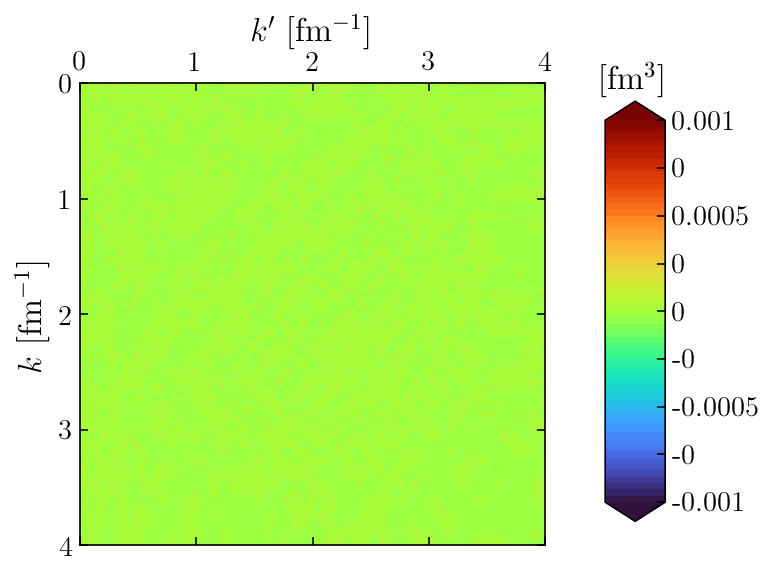

In [63]:
plot_delU_sum(k_array, zero_matrix.real, colorbar_limits=(-1e-3,1e-3))

## Test cancelation of matrix elements in plane wave basis

The plane-wave matrix elements of $\delta U$ can be expressed in terms of the partial wave matrix elements (with many sums and Clesbch-Gordan coefficients):

$$
\begin{align}
\delta U(\mathbf{k},\mathbf{k'}) &\equiv \langle \mathbf{k} \sigma_1 \tau_1 \sigma_2 \tau_2 \vert \delta U \vert \mathbf{k'} \sigma_3 \tau_3 \sigma_4 \tau_4 \rangle \\
&= \frac{1}{2} \frac{2}{\pi} \sum_{S M_S} \sum_{T M_T} \sum_{L M_L} \sum_{L' M_L'} \sum_{J M_J}
    \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S \vert \sigma_3 \sigma_4 \rangle
    \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau_3 \tau_4 \rangle
    \langle L M_L S M_S \vert J M_J \rangle \\
    &\qquad\times \langle J M_J \vert L M_L S M_S \rangle
    \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L'+S+T} \bigr)
    Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}})
    \langle k J (L S) T \vert \delta U \vert k' J (L' S) T \rangle
\end{align}
$$

$$
\begin{align}
0 &= \delta U(\mathbf{k},\mathbf{k'}) + \delta U^\dagger(\mathbf{k},\mathbf{k'}) 
    + \frac{1}{2} \sum_{\mathbf{q}} \delta U(\mathbf{k},\mathbf{q}) \delta U^\dagger(\mathbf{q},\mathbf{k'}) \\
&= \Bigl[
    \frac{1}{2} \frac{2}{\pi} \sum_{S M_S} \sum_{T M_T} \sum_{L M_L} \sum_{L' M_L'} \sum_{J M_J}
    \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S \vert \sigma_3 \sigma_4 \rangle
    \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau_3 \tau_4 \rangle
    \langle L M_L S M_S \vert J M_J \rangle \langle J M_J \vert L M_L S M_S \rangle \\
    &\qquad\times \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L'+S+T} \bigr)
    Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}})
    \bigl(
        \langle k J (L S) T \vert \delta U \vert k' J (L' S) T \rangle
        + \langle k J (L S) T \vert \delta U^\dagger \vert k' J (L' S) T \rangle
    \bigr) \\
    &\quad+ (\frac{1}{2} \frac{2}{\pi})^2 \sum_{\sigma \sigma'} \sum_{\tau \tau'}
    \sum_{S M_S} \sum_{T M_T} \sum_{L M_L} \sum_{L'' M_L''} \sum_{J M_J}
    \sum_{S' M_S'} \sum_{T' M_T'} \sum_{L''' M_L'''} \sum_{L' M_L'} \sum_{J' M_J'}
    \int_0^\infty dq q^2 \int d\Omega_{\mathbf{q}} \\
        &\qquad\times \langle \sigma_1 \sigma_2 \vert S M_S \rangle \langle S M_S \vert \sigma \sigma' \rangle
        \langle \sigma \sigma' \vert S' M_S' \rangle \langle S' M_S' \vert \sigma_3 \sigma_4 \rangle
        \langle \tau_1 \tau_2 \vert T M_T \rangle \langle T M_T \vert \tau \tau' \rangle
        \langle \tau \tau' \vert T' M_T' \rangle \langle T' M_T' \vert \tau_3 \tau_4 \rangle \\
        &\qquad\times \langle L M_L S M_S \vert J M_J \rangle \langle J M_J \vert L'' M_L'' S M_S \rangle
        \langle L''' M_L''' S' M_S' \vert J' M_J' \rangle \langle J' M_J' \vert L' M_L' S' M_S' \rangle \\
        &\qquad\times \bigl( 1-(-1)^{L+S+T} \bigr) \bigl( 1-(-1)^{L''+S+T} \bigr)
        \bigl( 1-(-1)^{L'''+S'+T'} \bigr) \bigl( 1-(-1)^{L'+S'+T'} \bigr)
        Y_{L M_L}(\Omega_{\mathbf{k}}) Y^*_{L'' M_L''}(\Omega_{\mathbf{q}})
        Y_{L''' M_L'''}(\Omega_{\mathbf{q}}) Y^*_{L' M_L'}(\Omega_{\mathbf{k'}}) \\
        &\qquad\times \langle k J (L S) T \vert \delta U \vert q J (L'' S) T \rangle
        \langle q J' (L''' S') T' \vert \delta U \vert k' J' (L' S') T' \rangle
\Bigr].
\end{align}
$$
To test the cancelation, we will fix the single-particle momenta $\mathbf{k}$ and $\mathbf{k'}$, the spin projections $\sigma_i$, and the isospin projections $\tau_i$.
In this way, we will output a number (that should be zero).

In [64]:
from sympy.physics.quantum.cg import CG

In [65]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for all combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)

    for j_1 in j_array:
        for m_1 in np.arange(-j_1, j_1+1, 1):
            for j_2 in j_array:
                for m_2 in np.arange(-j_2, j_2+1, 1):
                    for j_3 in j_array:
                        for m_3 in np.arange(-j_3, j_3+1, 1):
                            cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                            )
                                
    return cg_table

In [66]:
def get_total_isospin(L, S):
    """Total isospin according to antisymmetry."""
    
    # Make sure [1-(-1)^(L+S+T)] is not zero
    if (1-(-1)**(L+S)) == 0:
        T = 1
    else:
        T = 0
        
    return T

In [67]:
# MAKE THIS A FUNCTION OF k, \theta_k, \phi_k, k', \theta_k', \phi_k'
# SHOULD RETURN A NUMBER!
def delta_U_matrix_elements(
        k_grid, theta_k_grid, phi_k_grid, kp_grid, theta_kp_grid, phi_kp_grid,
        sigma_1, sigma_2, sigma_3, sigma_4, tau_1, tau_2, tau_3, tau_4,
        cg_table, channel, delta_U_func=None, delta_U_dag_func=None
):
    """Matrix element of \delta U or \delta U^\dagger in the plane-wave basis.
    """
    
    # Get channel quantum numbers
    L, Lp, S, J = get_channel_quantum_numbers(channel)
    T = get_total_isospin(L, S)
    
    if delta_U_func is not None:
        delta_U_partial_wave = delta_U_func.ev(k_grid, kp_grid)
    elif delta_U_dag_func is not None:
        delta_U_partial_wave = delta_U_dag_func.ev(k_grid, kp_grid)
    else:
        raise RuntimeError("Need to input a \delta U function!")
    
    # L S T factor
    lst_factor = 1-(-1)**(L+S+T)
    # L' S T factor
    lpst_factor = 1-(-1)**(Lp+S+T)
    
    # Restrict quantum numbers when possible
    M_S = sigma_1 + sigma_2
    if M_S != sigma_3 + sigma_4 or abs(M_S) > S:
        return 0
    spin_12_cg = cg_table[(1/2, sigma_1, 1/2, sigma_2, S, M_S)]
    spin_34_cg = cg_table[(1/2, sigma_3, 1/2, sigma_4, S, M_S)]
    
    M_T = tau_1 + tau_2
    if M_T != tau_3 + tau_4 or abs(M_T) > T:
        return 0
    isospin_12_cg = cg_table[(1/2, tau_1, 1/2, tau_2, T, M_T)]
    isospin_34_cg = cg_table[(1/2, tau_3, 1/2, tau_4, T, M_T)]
    
    # Loop over M_L and M_L'
    delta_U_plane_wave = np.zeros_like(k_grid, dtype='complex')
    for M_L in np.arange(-L, L+1, 1):
        
        M_J = M_L + M_S
        
        if abs(M_J) > J:
            
            return 0
        
        else:
            
            lsj_cg = cg_table[(L, M_L, S, M_S, J, M_J)]
            Y_L_k = sph_harm(M_L, L, phi_k_grid, theta_k_grid)
            
            for M_Lp in np.arange(-Lp, Lp+1, 1):
                
                if M_Lp + M_S != M_J:
                    
                    return 0
                
                else:
                    
                    lpsj_cg = cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
                    Y_Lp_kp = sph_harm(M_Lp, Lp, phi_kp_grid, theta_kp_grid)
                    
                    delta_U_plane_wave += (
                        1/2 * np.pi/2 * spin_12_cg * spin_34_cg
                        * isospin_12_cg * isospin_34_cg * lsj_cg * lpsj_cg
                        * Y_L_k * np.conj(Y_Lp_kp) * lst_factor * lpst_factor
                        * delta_U_partial_wave
                    )
    
    # Return 6-D array
    return delta_U_plane_wave

In [68]:
# MAKE THIS A FUNCTION OF k, \theta_k, \phi_k, k', \theta_k', \phi_k'
# BUILD q_grid, theta_q_grid, and phi_q_grid INSIDE FUNCTION
# SHOULD RETURN A NUMBER!
def delta_U2_matrix_element(
        k_grid, theta_k_grid, phi_k_grid, kp_grid, theta_kp_grid, phi_kp_grid,
        q_grid, theta_q_grid, phi_q_grid, dq_grid, dtheta_q_grid, dphi_q_grid,
        sigma_1, sigma_2, sigma_3, sigma_4, tau_1, tau_2, tau_3, tau_4,
        cg_table, channel, delta_U_func, delta_U_dag_func
):
    """Matrix element of \delta U \delta U^\dagger in the plane-wave basis."""
    
    # Jacobian for q_vector integration
    jacobian = (dq_grid * q_grid ** 2 * np.sin(theta_q_grid) * dtheta_q_grid
                * dphi_q_grid)
    
    # Sum over \sigma, \sigma', \tau, and \tau'
    integrand = np.zeros_like(k_grid, dtype='complex')
    spins = [1/2, -1/2]
    for sigma in spins:
        for sigmap in spins:
            for tau in spins:
                for taup in spins:
                    
                    delta_U_plane_wave = delta_U_matrix_elements(
                        k_grid, theta_k_grid, phi_k_grid, q_grid, theta_q_grid,
                        phi_q_grid, sigma_1, sigma_2, sigma, sigmap, tau_1,
                        tau_2, tau, taup, cg_table, channel,
                        delta_U_func=delta_U_func
                    )
                    
                    delta_U_dag_plane_wave = delta_U_matrix_elements(
                        q_grid, theta_q_grid, phi_q_grid, kp_grid,
                        theta_kp_grid, phi_kp_grid, sigma, sigmap, sigma_3,
                        sigma_4, tau, tau, tau_3, tau_4, cg_table, channel,
                        delta_U_dag_func=delta_U_dag_func
                    )
                    
                    integrand += (jacobian * delta_U_plane_wave
                                  * delta_U_dag_plane_wave)
    
    # Integrate over q_vector and return 6-D array
    return np.sum(np.sum(np.sum(integrand, axis=-1), axis=-1), axis=-1)

In [69]:
# SET k, \theta_k, \phi_k, k', \theta_k', \phi_k' INSTEAD OF THIS!
theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 5)
phi_array, phi_weights = gaussian_quadrature_mesh(2*np.pi, 5)
k_array, k_weights = gaussian_quadrature_mesh(5.0, 17)

# Set momenta
k, kp = 0.2, 0.2
# k, kp = 0.2, 2.5
# k, kp = 0.2, 4.5
# k, kp = 2.5, 2.5
# k, kp = 4.5, 4.5

# Set \theta
theta_k, theta_kp = 0.0, 0.0
# theta_k, theta_kp = 0.0, np.pi/4
# theta_k, theta_kp = 0.0, np.pi/2
# theta_k, theta_kp = 0.0, np.pi
# theta_k, theta_kp = np.pi/4, np.pi/4
# theta_k, theta_kp = np.pi/4, np.pi/2
# ...

# Set \phi
phi_k, phi_kp = 0.0, 0.0
# phi_k, phi_kp = 0.0, np.pi/4
# phi_k, phi_kp = np.pi/4, 5*np.pi/4

In [70]:
cg_table = compute_clebsch_gordan_table(4)

In [71]:
# Set spins, isospins, and channel
sigma_1, sigma_2, sigma_3, sigma_4 = 1/2, -1/2, 1/2, -1/2
tau_1, tau_2, tau_3, tau_4 = 1/2, -1/2, 1/2, -1/2

# YOU NEED TO SET ARGUMENTS IN
# "Testing cancelation of matrix elements with spherical harmonics included"
# FROM ABOVE!

In [72]:
# NO NEED FOR INTEGRATION FACTORS
# Create 6-D meshgrids for \delta U linear terms
(k_grid_6d, theta_k_grid_6d, phi_k_grid_6d, kp_grid_6d, theta_kp_grid_6d,
 phi_kp_grid_6d) = np.meshgrid(k_array, theta_array, phi_array, k_array,
                               theta_array, phi_array, indexing='ij')
(_, dtheta_k_grid_6d, dphi_k_grid_6d, _, dtheta_kp_grid_6d, dphi_kp_grid_6d) = (
    np.meshgrid(k_weights, theta_weights, phi_weights, k_weights, theta_weights,
                phi_weights, indexing='ij')
)

jacobian_6d = (np.sin(theta_k_grid_6d) * dtheta_k_grid_6d * dphi_k_grid_6d
               * np.sin(theta_kp_grid_6d) * dtheta_kp_grid_6d * dphi_kp_grid_6d)

In [73]:
# EVALUATE MATRIX ELEMENTS WHICH ARE NUMBERS NOT 6-D ARRAYS
# Evaluate \delta U and \delta U^\dagger 6-D arrays
delta_U_6d = delta_U_matrix_elements(
    k_grid_6d, theta_k_grid_6d, phi_k_grid_6d, kp_grid_6d, theta_kp_grid_6d,
    phi_kp_grid_6d, sigma_1, sigma_2, sigma_3, sigma_4, tau_1, tau_2, tau_3,
    tau_4, cg_table, channel, delta_U_func=delta_U_func
)

delta_U_dag_6d = delta_U_matrix_elements(
    k_grid_6d, theta_k_grid_6d, phi_k_grid_6d, kp_grid_6d, theta_kp_grid_6d,
    phi_kp_grid_6d, sigma_1, sigma_2, sigma_3, sigma_4, tau_1, tau_2, tau_3,
    tau_4, cg_table, channel, delta_U_dag_func=delta_U_dag_func
)

In [74]:
# THIS SHOULD BE IN THE FUNCTION AS 3-D ARRAYS
# Create 9-D meshgrids for \delta U^2 terms
(k_grid_9d, theta_k_grid_9d, phi_k_grid_9d, kp_grid_9d, theta_kp_grid_9d,
 phi_kp_grid_9d, q_grid_9d, theta_q_grid_9d, phi_q_grid_9d) = np.meshgrid(
    k_array, theta_array, phi_array, k_array, theta_array, phi_array,
    k_array, theta_array, phi_array, indexing='ij'
)

_, _, _, _, _, _, dq_grid_9d, dtheta_q_grid_9d, dphi_q_grid_9d = np.meshgrid(
    k_array, theta_array, phi_array, k_array, theta_array, phi_array, k_weights,
    theta_weights, phi_weights, indexing='ij'
)

In [75]:
# EVALUATE MATRIX ELEMENT WHICH IS A NUMBER AFTER INTEGRATING IN FUNCTION
delta_U2_6d = delta_U2_matrix_element(
    k_grid_9d, theta_k_grid_9d, phi_k_grid_9d, kp_grid_9d, theta_kp_grid_9d,
    phi_kp_grid_9d, q_grid_9d, theta_q_grid_9d, phi_q_grid_9d, dq_grid_9d,
    dtheta_q_grid_9d, dphi_q_grid_9d, sigma_1, sigma_2, sigma_3, sigma_4, tau_1,
    tau_2, tau_3, tau_4, cg_table, channel, delta_U_func, delta_U_dag_func
)

In [ ]:
# CREATE MAIN FUNCTION THAT RUNS THE PREVIOUS CELLS GIVEN PLANE-WAVE ARGUMENTS
# RETURNS A NUMBER (SHOULD BE ZERO)

In [76]:
# SHOULD BE A NUMBER NOT 6-D ARRAY
zero_matrix_6d = delta_U_6d + delta_U_dag_6d + delta_U2_6d
print(zero_matrix_6d.shape)

(17, 5, 5, 17, 5, 5)


In [77]:
# CAN PROBABLY DELETE THIS
# Integrate over \Omega_k and \Omega_k'
integrand = zero_matrix_6d * jacobian_6d

# If this seems tricky, print .shape of each and it will make sense
zero_matrix_4d = np.sum(np.sum(zero_matrix_6d, axis=-1), axis=-1)  # \Omega_k'
zero_matrix_2d = np.sum(np.sum(zero_matrix_4d, axis=-2), axis=-2)  # \Omega_k

# print(zero_matrix_2d)
print("Norm of matrix without integration weights = "
      f"{la.norm(zero_matrix_2d):.5f}.\n")

[[-1.66601084e+00+0.j -1.64688334e+00+0.j -1.55091885e+00+0.j
  -1.28197159e+00+0.j -7.44650320e-01+0.j -4.37468593e-02+0.j
   2.40982282e-01+0.j -1.27880257e-01+0.j -3.73350788e-01+0.j
  -2.85624450e-01+0.j -1.37278798e-01+0.j -6.14423178e-02+0.j
  -3.60816414e-02+0.j -2.56821968e-02+0.j -1.91946561e-02+0.j
  -1.50244026e-02+0.j -1.28457693e-02+0.j]
 [-1.64688334e+00+0.j -1.62817304e+00+0.j -1.53425389e+00+0.j
  -1.27072309e+00+0.j -7.42889266e-01+0.j -5.12278354e-02+0.j
   2.33392453e-01+0.j -1.29566474e-01+0.j -3.71877857e-01+0.j
  -2.83298216e-01+0.j -1.35174775e-01+0.j -5.99529404e-02+0.j
  -3.51305392e-02+0.j -2.50747153e-02+0.j -1.87817393e-02+0.j
  -1.47150314e-02+0.j -1.25843842e-02+0.j]
 [-1.55091885e+00+0.j -1.53425389e+00+0.j -1.45039269e+00+0.j
  -1.21355919e+00+0.j -7.32727975e-01+0.j -8.73912269e-02+0.j
   1.95909873e-01+0.j -1.37893132e-01+0.j -3.64429059e-01+0.j
  -2.71596439e-01+0.j -1.24610349e-01+0.j -5.24831198e-02+0.j
  -3.03626974e-02+0.j -2.20295802e-02+0.j -1.6

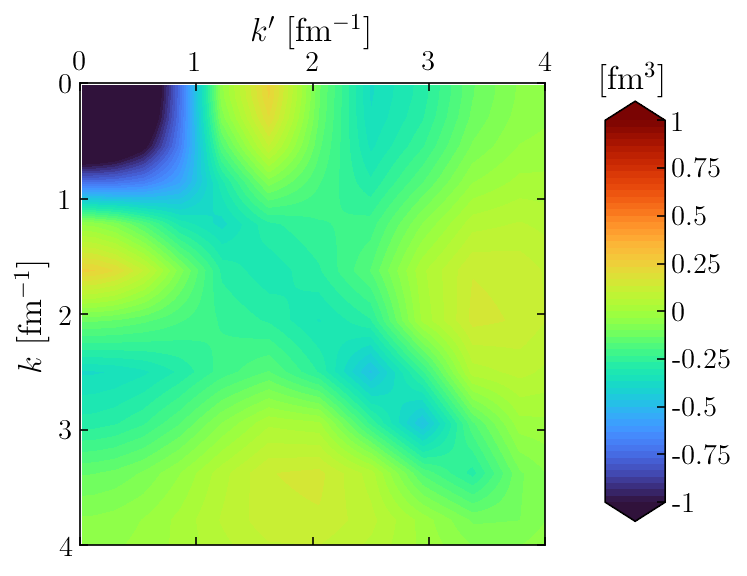

In [82]:
# CAN PROBABLY DELETE THIS
plot_delU_sum(k_array, zero_matrix_2d.real, colorbar_limits=(-1e0,1e0))